In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
#在执行用户代码前，重新装入软件的扩展和模块。
%load_ext autoreload
#autoreload 2：装入所有 %aimport 不包含的模块。
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
np.random.seed(1)

In [30]:
#填充一个5维向量，其中第二维用pad=1，第三维用pad=3，其余用0填充，constant_values=(x,y)，分别表示前面用x，后面用y填充
#a = np.pad(a, ((0,0),(1,1),(0,0),(3,3),(0,0)), 'constant', constant_values=(..,..))
#比如
import numpy as np
arr3D = np.array([[[1,2,3,4,5,6],
                   [1,2,3,4,5,6],
                   [1,2,3,4,5,6]],
                  
                 [[0,1,2,3,4,5],
                  [0,1,2,3,4,5],
                  [0,1,2,3,4,5]],
                  
                 [[1,1,2,2,3,4],
                  [1,1,2,2,3,4],
                  [1,1,2,2,3,4]]])
print(arr3D.shape)


(3, 3, 6)


In [40]:
print('Constant: \n'+str(np.pad(arr3D, ((0, 0), (1, 1),(2,2)), 'constant')))

Constant: 
[[[0 0 0 0 0 0 0 0 0 0]
  [0 0 1 2 3 4 5 6 0 0]
  [0 0 1 2 3 4 5 6 0 0]
  [0 0 1 2 3 4 5 6 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 2 3 4 5 0 0]
  [0 0 0 1 2 3 4 5 0 0]
  [0 0 0 1 2 3 4 5 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 1 1 2 2 3 4 0 0]
  [0 0 1 1 2 2 3 4 0 0]
  [0 0 1 1 2 2 3 4 0 0]
  [0 0 0 0 0 0 0 0 0 0]]]


In [55]:
def zero_pad(X, pad):
    """
    把数据集X的图像边界全部使用0来扩充pad个宽度和高度。
    
    参数：
        X - 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
        pad - 整数，每个图像在垂直和水平维度上的填充量
    返回：
        X_paded - 扩充后的图像数据集，维度为（样本数，图像高度 + 2*pad，图像宽度 + 2*pad，图像通道数）
    
    """
    X_paded = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values=0)
    return X_paded

In [71]:
np.random.seed(1)
X = np.random.randn(4,3,3,2)
X_paded = zero_pad(X,2)
print('X.shape= '+str(X.shape))
print('X_paded.shape= '+str(X_paded.shape))

X.shape= (4, 3, 3, 2)
X_paded.shape= (4, 7, 7, 2)


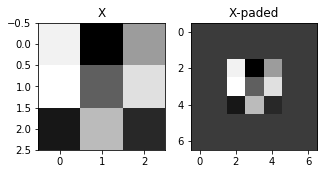

In [72]:
#绘制图
fig, axarr = plt.subplots(1,2)
axarr[0].set_title('X')
axarr[0].imshow(X[0,:,:,0])
axarr[1].set_title('X-paded')
axarr[1].imshow(X_paded[0,:,:,0])

In [74]:
#单步卷积 切片大小与过滤器大小相等
def conv_single_step(a_slice_prev,W,b):
    """
    在前一层的激活输出的一个片段上应用一个由参数W定义的过滤器。
    这里切片大小和过滤器大小相同
    
    参数：
        a_slice_prev - 输入数据的一个片段，维度为（过滤器大小，过滤器大小，上一通道数）
        W - 权重参数，包含在了一个矩阵中，维度为（过滤器大小，过滤器大小，上一通道数）
        b - 偏置参数，包含在了一个矩阵中，维度为（1,1,1）
        
    返回：
        Z - 在输入数据的片X上卷积滑动窗口（w，b）的结果。
    """
    s = np.multiply(a_slice_prev,W)+b
    Z = np.sum(s)
    return Z

In [76]:
np.random.seed(1)
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)
print('Z= '+str(conv_single_step(a_slice_prev,W,b)))

Z= -23.16021220252078


In [102]:
#卷积神经网络 前向传播
#在前向传播过程中，用多种过滤器对输入的数据进行卷积操作（通过设置过滤器的bias-b，挑选出图像的不同特征），每个过滤器产生一个2D的矩阵，堆叠起来就变成了一个高维的矩阵
def conv_forward(A_prev,W,b,hparameters):
    """
    实现卷积函数的前向传播
    
    参数：
        A_prev - 上一层的激活输出矩阵，维度为(m, n_H_prev, n_W_prev, n_C_prev)，（样本数量，上一层图像的高度，上一层图像的宽度，上一层过滤器数量）
        W - 权重矩阵，维度为(f, f, n_C_prev, n_C)，（过滤器大小，过滤器大小，上一层的过滤器数量，这一层的过滤器数量）
        b - 偏置矩阵，维度为(1, 1, 1, n_C)，（1,1,1,这一层的过滤器数量）
        hparameters - 包含了"stride"与 "pad"的超参数字典。
    
    返回：
        Z - 卷积输出，维度为(m, n_H, n_W, n_C)，（样本数，图像的高度，图像的宽度，过滤器数量）
        cache - 缓存了一些反向传播函数conv_backward()需要的一些数据
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev+2*pad-f)/stride+1)
    n_W = int((n_W_prev+2*pad-f)/stride+1)
    
    #使用0初始化卷积生成的矩阵
    Z = np.zeros((m,n_H,n_W,n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        #选择第i个样本
        a_prev_pad = A_prev_pad[i]
        print("A_prev_pad.shape = ",A_prev_pad.shape)
        print("a_prev_pad.shape = ",a_prev_pad.shape)
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位当前的切片位置
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    #b=[1,1,1,c]
                    Z[i,h,w,c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[0,0,0,c])
        
        #检查结果是否正确
        assert(Z.shape==(m,n_H,n_W,n_C))
        #存储缓存值，便于反向传播
        cache = (A_prev,W,b,hparameters)
        
        return(Z, cache)

In [103]:
np.random.seed(1)
#理解三者的维数关系
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad":2, "stride":1}

Z, cache_conv = conv_forward(A_prev,W,b,hparameters)

print("Z.shape = ",Z.shape)
print("np.mean(Z) = ",np.mean(Z))
print("cache_conv[0][1][2][3] = ",cache_conv[0][1][2][3])
#实际还应包含一个激活函数

A_prev_pad.shape =  (10, 8, 8, 3)
a_prev_pad.shape =  (8, 8, 3)
Z.shape =  (10, 7, 7, 8)
np.mean(Z) =  0.01557186883457127
cache_conv[0][1][2][3] =  [-0.20075807  0.18656139  0.41005165]


In [121]:
#池化层
def pool_forward(A_prev,hparameters,mode="max"):
    """
    实现池化层的前向传播
    
    参数：
        A_prev - 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        hparameters - 包含了 "f" 和 "stride"的超参数字典
        mode - 模式选择【"max" | "average"】
        
    返回：
        A - 池化层的输出，维度为 (m, n_H, n_W, n_C)
        cache - 存储了一些反向传播需要用到的值，包含了输入和超参数的字典。
    """
    f = hparameters["f"]
    stride = hparameters["stride"]
    m,n_H_prev,n_W_prev,n_C_prev = A_prev.shape
    
    #计算输出的维度
    n_H = int((n_H_prev-f)/stride+1)
    n_W = int((n_W_prev-f)/stride+1)
    n_C = n_C_prev
    
    A = np.zeros((m,n_H,n_W,n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    #定位切片
                    a_slice_prev = A_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                    #对切片进行池化操作
                    if mode=="max":
                        A[i,h,w,c] = np.max(a_slice_prev)
                    elif mode=="average":
                        A[i,h,w,c] = np.mean(a_slice_prev)
                    
    #检查
    assert(A.shape==(m,n_H,n_W,n_C))
    #保存缓存值用于反向传播
    cache = (A_prev,hparameters)
    
    return A,cache                

In [123]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters={"f":4,"stride":1}

A,cache = pool_forward(A_prev,hparameters,"max")
print("mode=max")
print("A = ",A)
print("mode=average")
A,cache = pool_forward(A_prev,hparameters,"average")
print("A= ",A)

mode=max
A =  [[[[1.65980218 1.12948391 2.18557541]]]


 [[[1.65980218 1.12948391 2.18557541]]]]
mode=average
A=  [[[[ 0.20126166 -0.30295078  0.328328  ]]]


 [[[ 0.20126166 -0.30295078  0.328328  ]]]]
